In [3]:
import os
import random
import re
from pathlib import Path
import numpy as np 
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from skimage import io
import cv2
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import skimage.measure
import shutil
import skimage.io as io
from skimage import color
import skimage.feature

In [5]:
# patient_dir = 'thesis/IDC_regular_ps50_idx5/'
# patient_list = os.listdir(patient_dir) 

In [10]:
originalData = pd.read_csv('Original_data.csv')

In [11]:
originalData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277524 entries, 0 to 277523
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  277524 non-null  int64 
 1   Patient ID  277524 non-null  int64 
 2   Diagnosis   277524 non-null  int64 
 3   Pathes      277524 non-null  object
dtypes: int64(3), object(1)
memory usage: 8.5+ MB


In [12]:
paths = originalData['Pathes'].tolist()

In [13]:
path_data = {'path':[],'patient_id':[],'x_coord':[] ,'y_coord':[],'target':[]}
pattern = '\/(\d+)_.+_x(\d+)_y(\d+)_.+(\d)'
for path in paths:
    info = re.search(pattern, str(path))
    path_data['path'].append(path)
    path_data['patient_id'].append(info.group(1))
    path_data['x_coord'].append(info.group(2))
    path_data['y_coord'].append(info.group(3))
    path_data['target'].append(info.group(4))
    

In [14]:
df = pd.DataFrame.from_dict(path_data)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277524 entries, 0 to 277523
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   path        277524 non-null  object
 1   patient_id  277524 non-null  object
 2   x_coord     277524 non-null  object
 3   y_coord     277524 non-null  object
 4   target      277524 non-null  object
dtypes: object(5)
memory usage: 10.6+ MB


In [17]:
for col in df.iloc[:,2:5]:
    df[col] = df[col].astype('int')

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277524 entries, 0 to 277523
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   path        277524 non-null  object
 1   patient_id  277524 non-null  object
 2   x_coord     277524 non-null  int64 
 3   y_coord     277524 non-null  int64 
 4   target      277524 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 10.6+ MB


In [19]:
df['target'].value_counts()

0    198738
1     78786
Name: target, dtype: int64

In [30]:
benign_df = df[df['target'] == 0]
malignant_df = df[df['target'] == 1]

In [42]:
sample_benign = np.random.choice(benign_df['path'])

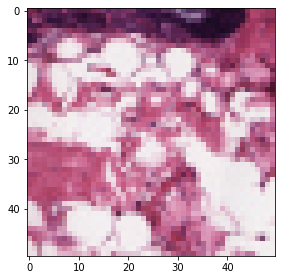

In [43]:
io.imshow(io.imread(sample_benign))

In [44]:
sample_malignant = np.random.choice(malignant_df['path'])

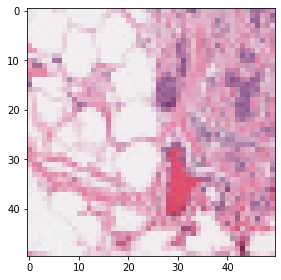

In [45]:
io.imshow(io.imread(sample_malignant))

In [22]:
def get_patient_df(p_id,df=df):
    return df.loc[df['patient_id']== p_id,:] 

In [25]:
def get_tissue_image_array(patient_id):
    path_df = get_patient_df(patient_id)
    max_coord = np.max((*path_df['x_coord'],*path_df['y_coord']))
    image_dimension = max_coord + 50
    grid = 255*np.ones(shape = (image_dimension,image_dimension,3)).astype('uint8')
    mask = 255*np.ones(shape = (image_dimension,image_dimension,3)).astype('uint8')
    for x,y,target,path in path_df[['x_coord','y_coord','target','path']].values:
        img_array = io.imread(path)
        try:
            grid[y:y+50,x:x+50] = img_array 
            if target != 0:
                mask[y:y+50,x:x+50] = [0,0,255]
        except: pass
        
    return grid

In [28]:
def plot_tissue_images(nrows=2,ncols=2,df=df):
    n_imgs = nrows*ncols
    p_ids = np.random.choice(df['patient_id'].unique(), size=n_imgs, replace=False)
    
    fig,axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(30,30))
    for i,row in enumerate(axs):
        for j,ax in enumerate(row):
            p_id = p_ids[i*nrows+j]
            img = get_tissue_image_array(p_id)
            ax.set_title(f'Breast Tissue Slice for patient {p_id}')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(img)

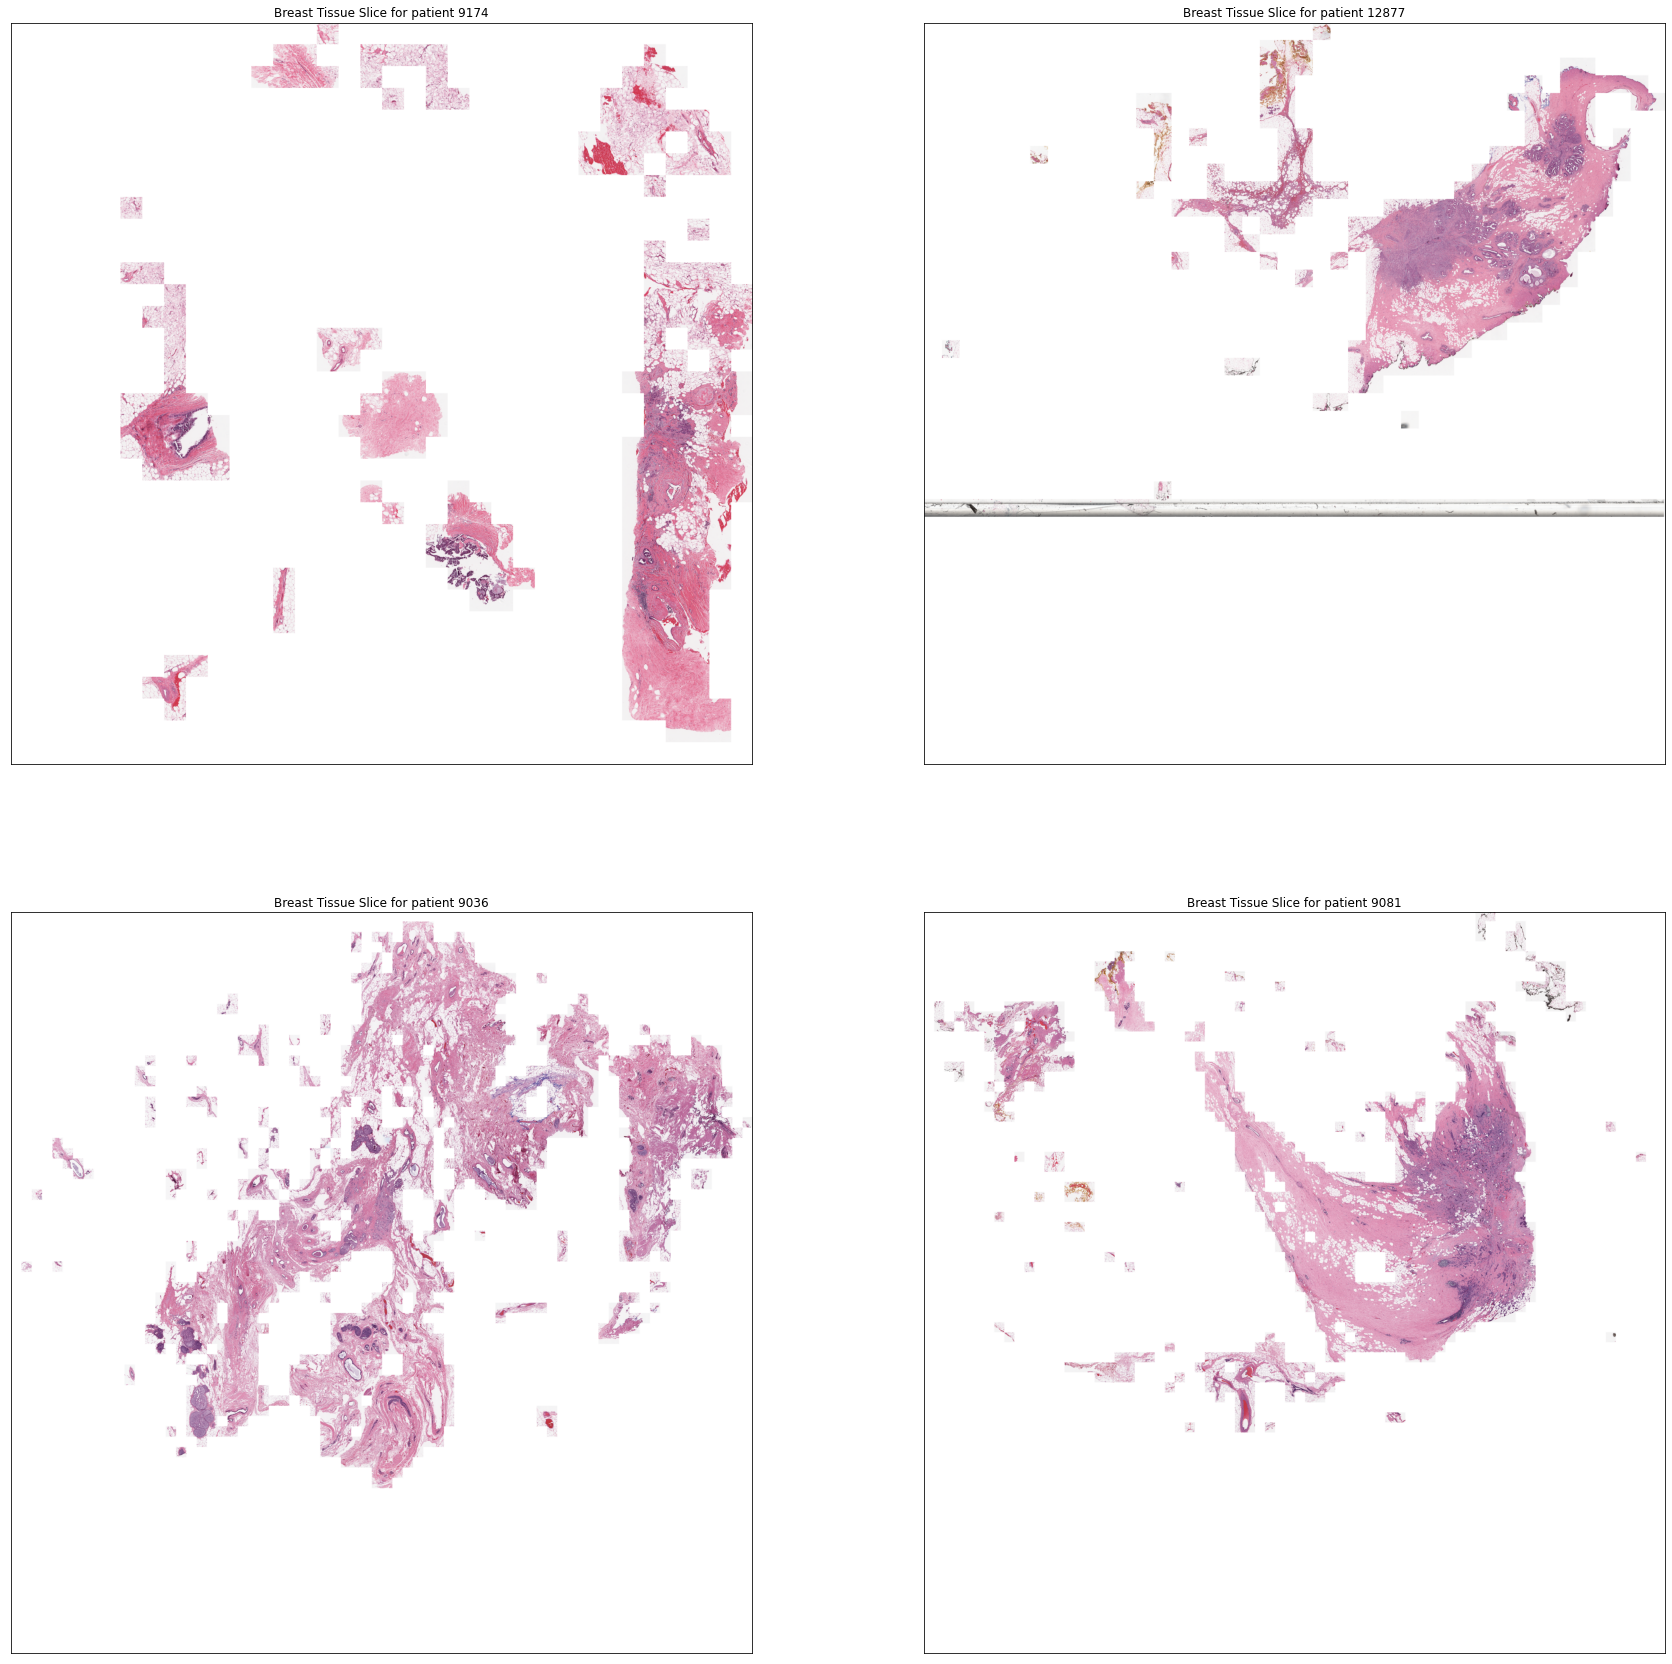

In [29]:
plot_tissue_images()